In [4]:
!pip install webdriver_manager

In [11]:
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import time

In [14]:
def get_housing_info(df,bs_data):
    houses = bs_data.find_all("article", attrs = {"class" : "T_7706df6d _3f10vd _269xmc T_25ec224f _raf0g3nn _rz5zidpf _5jexct _9jtlke _gi1tjx T_a3fd8ac3 _biqgexct _7lr3uz _uc167d _mkh2mm _ar1bp4 _9s1txw _40h1u4"})
    for each_house in houses:
        try:
            Price = each_house.find("div", attrs = {"class" : "_csbfng _c8exct _g3qslr _fr1nms _1q73f6fq _4okugktf _1qkcc65e _j3gpidpf _4nrxyh40 T_a6707275"}).text
        except:
            Price = np.nan
        try:
            Type = each_house.find("div", attrs = {"class" : "T_091c165f _sq1l2s _vv1q9c _ks15vq T_3d3547ab _7s5wglyw _5vy24jg8 _blas1v10 new-title"}).text
            type_of_house=re.match(r"\d\s[A-Za-z]+",Type)
            type_of_house = type_of_house.group()
            location = re.search(r"[^in\s][a-zA-z]*\s?[a-zA-Z]+,",Type).group()
            location = location[:len(location)-1]
        except:
            type_of_house = np.nan
            location = np.nan
            
        try:
            Property_Type = re.search(r"(Flat)|(Villa)|(Independent House)|(Independent Builder Floor)", Type).group()
        except:
            Property_Type = np.nan
            
            
        internal_link = each_house.find("a", attrs = {"class" : "_csbfng _c8dlk8 _frwh2y _ll6yew _1q73uea4 T_023f8db6 _ks15vq _vv1q9c _sq1l2s T_091c165f"})
        internal_link = internal_link["href"]
        internal_link = f"https://housing.com{internal_link}"

        driver.get(internal_link)
        internal_bs_data = BeautifulSoup(driver.page_source, 'html.parser')

        headings = internal_bs_data.find_all("th", attrs = {"class" : "_7l11ef T_8cd85f88"})
        values = internal_bs_data.find_all("div", attrs = {"class" : "_h3i2wt T_46c25558"})
        if len(headings) == len(values):
            for i in range(len(values)):
                if headings[i].text == "Brokerage":
                    Brokerage = values[i].text
                elif headings[i].text == "Built up area":
                    Area = values[i].text
                elif headings[i].text == "Furnishing":
                    Furnish = values[i].text
                elif headings[i].text == "Bathrooms":
                    Bathrooms = values[i].text
        else:
            for i in range(len(headings)):
                if headings[i].text == "Brokerage":
                    Brokerage = values[i-1].text
                elif headings[i].text == "Built up area":
                    Area = values[i-1].text
                elif headings[i].text == "Furnishing":
                    Furnish = values[i-1].text
                elif headings[i].text == "Bathrooms":
                    Bathrooms = values[i-1].text
        
            
                
        data_dict = {"type_of_house" : type_of_house,
                     "Property_Type" : Property_Type,
                "Price" : Price,
                "Brokerage" : Brokerage,
                "location" : location,
                "Furnish" : Furnish,
                "Area" : Area,
                "Bathrooms" : Bathrooms}
        
        each_df = pd.DataFrame(data_dict, index = [0])
    
        df = pd.concat((df, each_df), ignore_index = True)
    
    return df

In [15]:
from selenium import webdriver

from selenium.webdriver.chrome.service import Service

from selenium.webdriver.chrome.options import Options

from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.keys import Keys

from selenium.webdriver.common.by import By



driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))


df = pd.DataFrame()
for each_page in range(1,20):
    page_link = f"https://housing.com/rent/bachelor-flats-for-rent-in-hyderabad-telangana-L4P679xe73u28050522?page={each_page}"
    driver.get(page_link)
    
    time.sleep(2)
    bs_data =  BeautifulSoup(driver.page_source, 'html.parser')
    df = get_housing_info(df,bs_data)
    
    print(f"processed page {each_page}")
    
driver.quit()

processed page 1
processed page 2
processed page 3
processed page 4
processed page 5
processed page 6
processed page 7
processed page 8
processed page 9
processed page 10
processed page 11
processed page 12
processed page 13
processed page 14
processed page 15
processed page 16
processed page 17
processed page 18
processed page 19


In [17]:
df["Price"] = df["Price"].apply(lambda x: re.sub("[^\d]", "", x))
df["Price"] = df["Price"].astype(int)

In [ ]:
df["Area"] = df["Area"].apply(lambda x: re.sub("[^\d]", "", x))
df["Area"] = df["Area"].astype(int)


In [ ]:
df.rename(columns = {"type_of_house" : "Type_of_House", "Area" : "Area_in_sqft", "location" : "Location"}, inplace = True)

df["Bathrooms"] = df["Bathrooms"].astype(int)

In [ ]:
df["Brokerage"] = df["Brokerage"].apply(lambda x: re.sub("[^\d]", "", x) if x[-4:].lower() != "lacs" else float(re.sub("[^\d.]", "", x))*100000 )

In [24]:
df.to_csv("Project_final.csv", index = False)

In [25]:
df = pd.read_csv("Project_final.csv")

In [26]:
df

,Type_of_House,Property_Type,Price,Brokerage,Location,Furnish,Area_in_sqft,Bathrooms
0,3 BHK,Flat,100000,50000.0,Jubilee Hills,Fully Furnished,2500,3
1,4 BHK,Flat,70000,70000.0,Nizampet,Semi Furnished,3063,4
2,3 BHK,Flat,45000,45000.0,Chitrapuri Colony,Semi Furnished,2063,3
3,4 BHK,Villa,120000,120000.0,Madhapur,Fully Furnished,3000,4
4,2 BHK,Flat,29000,16000.0,Hafeezpet,Semi Furnished,1200,2
...,...,...,...,...,...,...,...,...
563,2 BHK,Flat,42000,26000.0,Kondapur,Fully Furnished,1250,2
564,2 BHK,Flat,28000,18000.0,Kondapur,Semi Furnished,1250,1
565,3 BHK,Flat,50000,32000.0,Kondapur,Fully Furnished,1850,3
566,1 BHK,Flat,17000,16500.0,Kondapur,Semi Furnished,650,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type_of_House  568 non-null    object 
 1   Property_Type  568 non-null    object 
 2   Price          568 non-null    int64  
 3   Brokerage      567 non-null    float64
 4   Location       568 non-null    object 
 5   Furnish        568 non-null    object 
 6   Area_in_sqft   568 non-null    int64  
 7   Bathrooms      568 non-null    int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 35.6+ KB


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# UNIVARIATE ANALYSIS

## Price

In [36]:
df["Price"].mean()

35245.70070422535

In [37]:
df["Price"].median()

28000.0

In [38]:
df["Price"].mode()

0    28000
Name: Price, dtype: int64

#### Observations

1. Average price of houses is about 35000/-
2. As mean of the price is around 35000, so most of the price of houses might be around 35000 Rs/-
------------------------------------------------------------------------------------------------------------------------------
3. According the the above analysis,the median price is about 28000/-
4. So from the above numbers we can interpret that there might chance of outliers at postive side
    because mean is greater than median, which indicates that very few houses have higher prices.
------------------------------------------------------------------------------------------------------------------------------   
5. Most of the houses prices are about 25000/-
6. mean > median > mode

In [39]:
# Range

df["Price"].max() - df["Price"].min()

240000

In [40]:
#Variance (Sample)

df["Price"].var(ddof = 1)

645790743.0566515

In [41]:
#standard Deviation (Sample)

df["Price"].std(ddof = 1)

25412.413168698706

#### Observations

1. Standard deviation of price of houses is around 25000, which indicate on average there is deviation of 25000 RS/- from mean (35000/-)
2. Most of the prices of houses are with deviation of 25000/-
3. So, we can conclude that the spread of the price data is less.

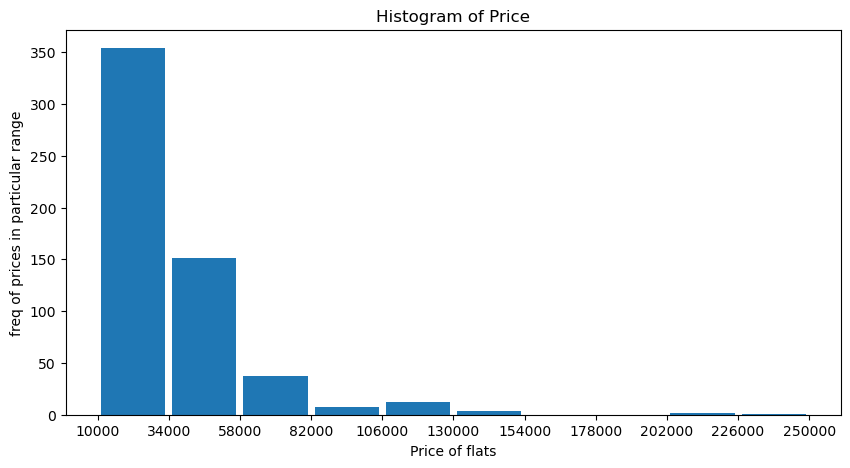

In [42]:
#histogram

#np.set_printoptions(precision = 2, suppress = True)
plt.figure(figsize = (10,5))
freq,bins,plot = plt.hist(df["Price"], bins = 10, rwidth = 0.9)
plt.xticks(bins)
plt.xlabel("Price of flats")
plt.ylabel("freq of prices in particular range")
plt.title("Histogram of Price")
plt.show()

#### Observations

1. Majority of the prices are in the range of 10000 to 34000 followed by 34000 to 58000
2. Very few houses/flats are at higher price.

In [43]:
#skewness

df["Price"].skew()

3.6467486147254125

#### Observations 

+ The prices of houses data is highly positive skew.
+ Most of the houses are at lower price and very few are at higher price

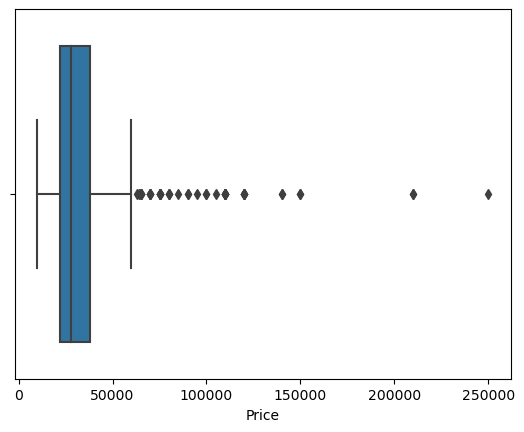

In [44]:
#Boxplot

sns.boxplot(x = df["Price"])
plt.show()

In [45]:
#IQR

q1 = df["Price"].quantile(q = 0.25)

q3 = df["Price"].quantile(q = 0.75)

IQR = q3 - q1
IQR

16000.0

#### Observations
 1. Almost 75% of the houses are at price below 50000/-
 2. The spread of the data is less

In [46]:
# Finding outliers

lower_boundary = q1 - (1.5 * IQR)
upper_boundary = q3 + (1.5 * IQR)

print(lower_boundary)
print(upper_boundary)

df[(df["Price"] < lower_boundary) | (df["Price"] > upper_boundary)]

-2000.0
62000.0


,Type_of_House,Property_Type,Price,Brokerage,Location,Furnish,Area_in_sqft,Bathrooms
0,3 BHK,Flat,100000,50000.0,Jubilee Hills,Fully Furnished,2500,3
1,4 BHK,Flat,70000,70000.0,Nizampet,Semi Furnished,3063,4
3,4 BHK,Villa,120000,120000.0,Madhapur,Fully Furnished,3000,4
19,3 BHK,Flat,140000,140000.0,Nallagandla,Fully Furnished,5000,3
20,3 BHK,Villa,110000,110000.0,Kokapet,Fully Furnished,2800,3
30,2 BHK,Flat,75000,75000.0,Narsingi,Semi Furnished,2656,2
31,4 BHK,Flat,100000,1.0,Toli Chowki,Semi Furnished,5981,4
32,4 BHK,Flat,90000,90000.0,Nanakaramguda,Semi Furnished,3560,4
40,3 BHK,Flat,65000,65000.0,Toli Chowki,Fully Furnished,2981,3
42,3 BHK,Flat,75000,37500.0,Banjara Hills,Fully Furnished,2500,2


## Type of Houses

In [47]:
df["Type_of_House"].unique()

array(['3 BHK', '4 BHK', '2 BHK', '1 BHK', '5 BHK', '1 RK'], dtype=object)

In [48]:
df["Type_of_House"].nunique()

6

In [49]:
#Freq Distribution Table

fdt_typeOfHouses = df["Type_of_House"].value_counts()

In [51]:
fdt_typeOfHouses

Type_of_House
1 BHK    218
2 BHK    209
3 BHK    111
4 BHK     19
1 RK       9
5 BHK      2
Name: count, dtype: int64

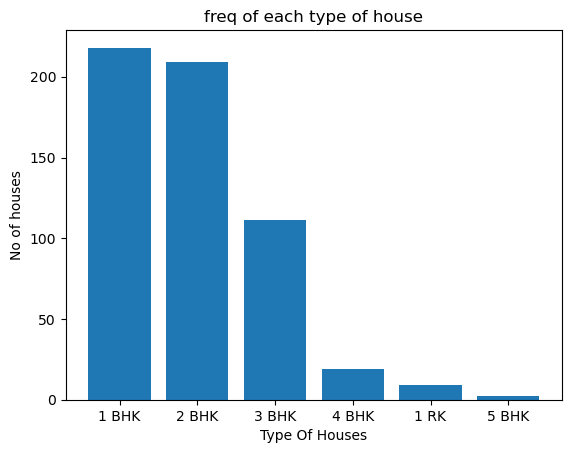

In [52]:
#bar chart

plt.bar(fdt_typeOfHouses.index, fdt_typeOfHouses.values)
plt.xlabel("Type Of Houses")
plt.xticks(fdt_typeOfHouses.index)
plt.ylabel("No of houses")
plt.title("freq of each type of house")
plt.show()

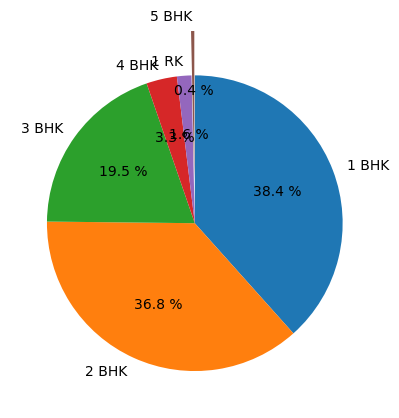

In [53]:
#pie chart

plt.pie(fdt_typeOfHouses, labels = fdt_typeOfHouses.index, 
        autopct = "%.1f %%", 
        explode = [0, 0, 0, 0, 0, 0.3],
        startangle = 90,
        counterclock=False)
plt.show()

#### Observations

1. 1BHK flats/houses are top in count i.e 218 houses followed by 2BHK(109 houses).
2. 5BHK flats/houses are least in count(only 2 houses).
---------------------------------------------------------------------------------------------------------------
3. Almost 38% of houses are of 1BHK followed by 2BHK with 36%.
4. Only 0.4% of houses are 5BHK which is very low category.

## Property_Type

In [100]:
fdt_property = df["Property_Type"].value_counts()
fdt_property

Property_Type
Flat                         554
Villa                         13
Independent Builder Floor      1
Name: count, dtype: int64

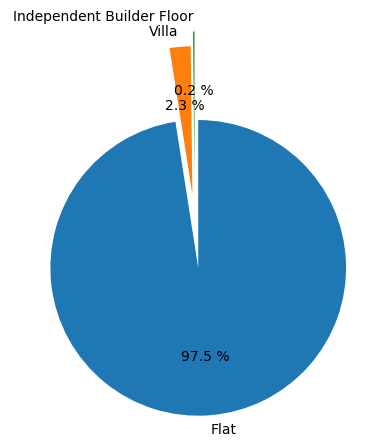

In [105]:
plt.pie(fdt_property, labels = fdt_property.index, 
        autopct = "%.1f %%", 
        explode = [0.3, 0.2, 0.3],
        startangle = 90,
        counterclock=False)
plt.show()

#### Observations

+ Almost all the houses are flats in an apartment i.e about 98%.

## Location

In [54]:
df["Location"].unique()

array(['Jubilee Hills', 'Nizampet', 'Chitrapuri Colony', 'Madhapur',
       'Hafeezpet', 'Kondapur', 'Nallagandla', 'Kokapet', 'Nanakaramguda',
       'Narsingi', 'Toli Chowki', 'Gopanapalli', 'Kukatpally',
       'Borabanda', 'Manikonda', 'Banjara Hills', 'Gachibowli',
       'Serilingampally', 'Peeramcheru', 'Tellapur', 'Hitech City',
       'Shaikpet', 'Kothaguda', 'Osman Nagar'], dtype=object)

In [55]:
df["Location"].nunique()

24

In [56]:
#FDT

fdt_locations = df["Location"].value_counts()
fdt_locations

Location
Kondapur             465
Hafeezpet             16
Kokapet               12
Madhapur              12
Nanakaramguda          9
Nallagandla            7
Serilingampally        6
Kukatpally             6
Tellapur               5
Toli Chowki            3
Borabanda              3
Manikonda              3
Banjara Hills          3
Gachibowli             3
Kothaguda              2
Hitech City            2
Peeramcheru            2
Osman Nagar            2
Narsingi               2
Nizampet               1
Gopanapalli            1
Shaikpet               1
Chitrapuri Colony      1
Jubilee Hills          1
Name: count, dtype: int64

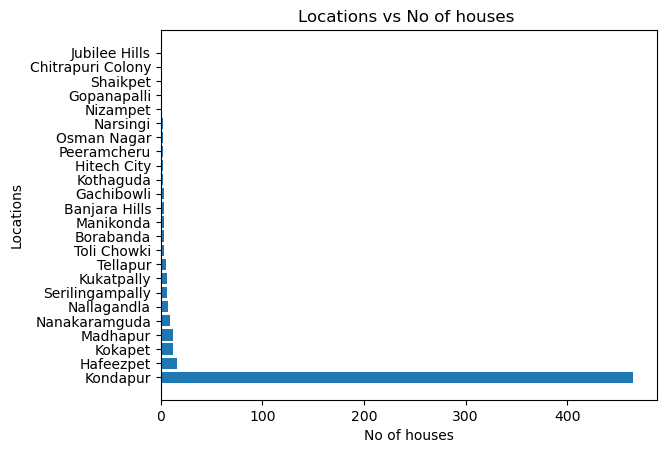

In [57]:
#bar chart

plt.barh(fdt_locations.index, fdt_locations.values)
plt.ylabel("Locations")
plt.yticks(fdt_locations.index)
plt.xlabel("No of houses")
plt.title("Locations vs No of houses ")
plt.show()

#### Observations

1. Almost all houses are available at Kondapur.
2. Many places like Shaikpet, Jubilee Hills, Nizampet, Chitrapuri Colony, Gopanapalli atmost have 1 house.         

## Furnish

In [58]:
df["Furnish"].unique()

array(['Fully Furnished', 'Semi Furnished', 'Unfurnished'], dtype=object)

In [59]:
#FDT

fdt_furnish = df["Furnish"].value_counts()
fdt_furnish

Furnish
Semi Furnished     327
Fully Furnished    200
Unfurnished         41
Name: count, dtype: int64

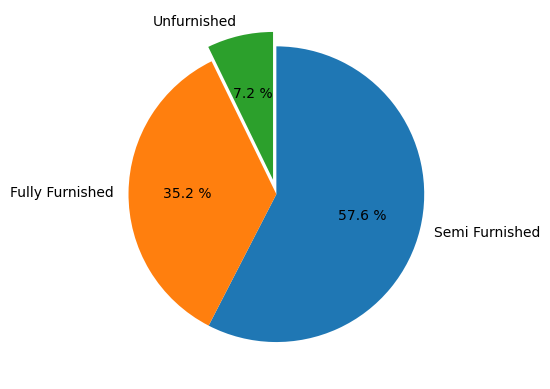

In [60]:
# pie chart 

plt.pie(fdt_furnish, labels = fdt_furnish.index, 
        autopct = "%.1f %%", 
        explode = [0, 0, 0.1],
        startangle = 90,
        counterclock=False)
plt.show()

#### Observations

1. Almost 58% of houses are semi furnished followed by fully furnished with 35%.
2. Only 7.2% of houses are not furnished.

# BIVARIATE ANALYSIS

In [61]:
df

,Type_of_House,Property_Type,Price,Brokerage,Location,Furnish,Area_in_sqft,Bathrooms
0,3 BHK,Flat,100000,50000.0,Jubilee Hills,Fully Furnished,2500,3
1,4 BHK,Flat,70000,70000.0,Nizampet,Semi Furnished,3063,4
2,3 BHK,Flat,45000,45000.0,Chitrapuri Colony,Semi Furnished,2063,3
3,4 BHK,Villa,120000,120000.0,Madhapur,Fully Furnished,3000,4
4,2 BHK,Flat,29000,16000.0,Hafeezpet,Semi Furnished,1200,2
...,...,...,...,...,...,...,...,...
563,2 BHK,Flat,42000,26000.0,Kondapur,Fully Furnished,1250,2
564,2 BHK,Flat,28000,18000.0,Kondapur,Semi Furnished,1250,1
565,3 BHK,Flat,50000,32000.0,Kondapur,Fully Furnished,1850,3
566,1 BHK,Flat,17000,16500.0,Kondapur,Semi Furnished,650,1


##### type of houses vs location

In [65]:
pd.crosstab(df["Type_of_House"], df["Location"], margins = True, margins_name = "Total_houses")

Location,Banjara Hills,Borabanda,Chitrapuri Colony,Gachibowli,Gopanapalli,Hafeezpet,Hitech City,Jubilee Hills,Kokapet,Kondapur,...,Nanakaramguda,Narsingi,Nizampet,Osman Nagar,Peeramcheru,Serilingampally,Shaikpet,Tellapur,Toli Chowki,Total_houses
Type_of_House,,,,,,,,,,,,,,,,,,,,,
1 BHK,0,0,0,0,0,11,0,0,0,203,...,0,0,0,0,0,0,0,0,0,218
1 RK,0,0,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,9
2 BHK,0,2,0,3,0,5,0,0,1,182,...,1,1,0,1,0,2,0,0,0,209
3 BHK,3,1,1,0,1,0,1,1,8,70,...,7,0,0,1,0,4,1,1,1,111
4 BHK,0,0,0,0,0,0,1,0,3,1,...,1,1,1,0,2,0,0,2,2,19
5 BHK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,2
Total_houses,3,3,1,3,1,16,2,1,12,465,...,9,2,1,2,2,6,1,5,3,568


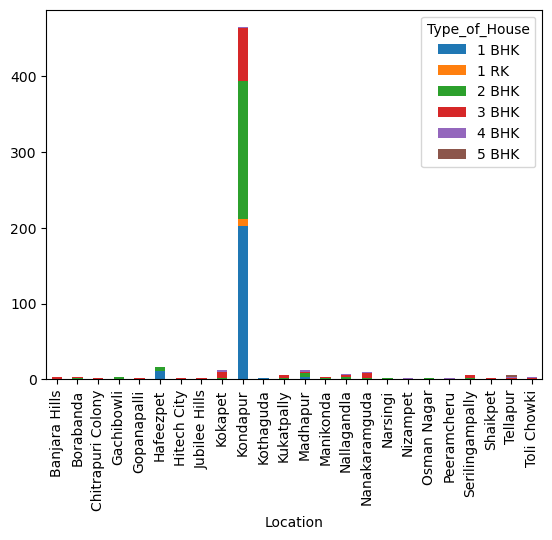

In [66]:
# Stacked Bar Chart

ct_tyL = pd.crosstab(df["Location"], df["Type_of_House"])
ct_tyL.plot(kind = "bar", stacked = True)
plt.show()

In [64]:
#groupby

gp_Type = df.groupby(by = "Type_of_House")
gp_Type["Location"].nunique()

Type_of_House
1 BHK     4
1 RK      1
2 BHK    13
3 BHK    19
4 BHK    12
5 BHK     1
Name: Location, dtype: int64

#### Observations

1. All types of houses are present in kondapur but 5BHK and 4BHK counts are very less compared to other types.
2. All other locations have very less no of houses(including type of houses) compared to kondapur.
3. 5BHK flats are present only at Tellapur.
---------------------------------------------------------------------------------------------------------------------------
4. 3BHK flats are present at many locations(19 locations) followed by 2BHK and 4BHK flats at 13 and 12 locations respectively.
5. 5BHK flats are present onlt at one location and 1RK flats are present only at 1 locations.

##### types of houses vs Furnish

In [94]:
pd.crosstab(df["Type_of_House"], df["Furnish"])

Furnish,Fully Furnished,Semi Furnished,Unfurnished
Type_of_House,,,
1 BHK,88,96,34
1 RK,3,3,3
2 BHK,66,139,4
3 BHK,36,75,0
4 BHK,7,12,0
5 BHK,0,2,0


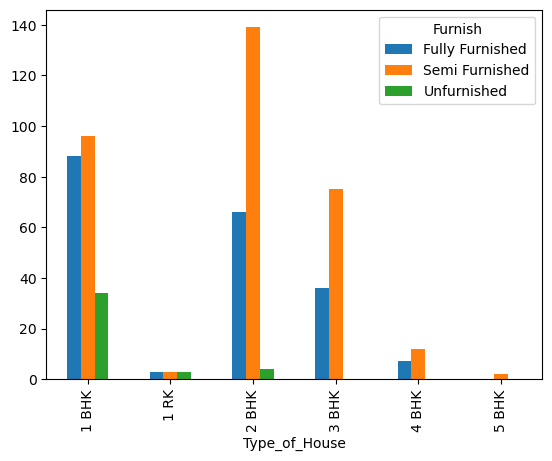

In [68]:
#Bar Chart

ct_tyF = pd.crosstab(df["Type_of_House"], df["Furnish"])
ct_tyF.plot(kind = "bar")
plt.show()

#### Observations

1. Semi furnished are most 2BHK followed by 1BHK then followed by 3BHK.
2. Fully Furnished are most 1BHK followed by 2BHK.
3. Very less 2BHK are not furnished.
4. none of 3BHK, 4BHK, 5BHK flats remained unfurnished.

##### Furnish vs Location

In [69]:
pd.crosstab(df["Furnish"], df["Location"],  margins = True, margins_name = "Total_houses")

Location,Banjara Hills,Borabanda,Chitrapuri Colony,Gachibowli,Gopanapalli,Hafeezpet,Hitech City,Jubilee Hills,Kokapet,Kondapur,...,Nanakaramguda,Narsingi,Nizampet,Osman Nagar,Peeramcheru,Serilingampally,Shaikpet,Tellapur,Toli Chowki,Total_houses
Furnish,,,,,,,,,,,,,,,,,,,,,
Fully Furnished,2,2,0,1,0,5,1,1,7,156,...,4,0,0,1,1,2,1,2,1,200
Semi Furnished,1,1,1,2,1,10,1,0,5,269,...,5,2,1,1,1,4,0,3,2,327
Unfurnished,0,0,0,0,0,1,0,0,0,40,...,0,0,0,0,0,0,0,0,0,41
Total_houses,3,3,1,3,1,16,2,1,12,465,...,9,2,1,2,2,6,1,5,3,568


In [70]:
#groupby

gp_L = df.groupby(by = "Location")
gp_L["Furnish"].nunique()

Location
Banjara Hills        2
Borabanda            2
Chitrapuri Colony    1
Gachibowli           2
Gopanapalli          1
Hafeezpet            3
Hitech City          2
Jubilee Hills        1
Kokapet              2
Kondapur             3
Kothaguda            1
Kukatpally           2
Madhapur             2
Manikonda            1
Nallagandla          2
Nanakaramguda        2
Narsingi             1
Nizampet             1
Osman Nagar          2
Peeramcheru          2
Serilingampally      2
Shaikpet             1
Tellapur             2
Toli Chowki          2
Name: Furnish, dtype: int64

#### Observations

1. Almost all houses at all locations are either fully or semi furnished except kondapur and hafeezpet.

##### Type of houses vs Price

In [97]:
gp_Type.agg({"Price" : ["mean"]})["Price"]

,mean
Type_of_House,
1 BHK,20206.591743
1 RK,13444.444444
2 BHK,33557.110048
3 BHK,54234.234234
4 BHK,116845.947368
5 BHK,120006.000000


In [71]:
gp_Type.agg({"Price" : ["mean", "median", "skew", "std", "min", "max", "count"]})

Price                                            \
                        mean    median      skew           std     min   
Type_of_House                                                            
1 BHK           20206.591743   20000.0 -0.092252   3918.326001   12000   
1 RK            13444.444444   13000.0  1.507800   3908.679800   10000   
2 BHK           33557.110048   32000.0  1.838200   7957.262580   21000   
3 BHK           54234.234234   46000.0  2.933391  26197.832997   30000   
4 BHK          116845.947368  110012.0  1.756198  46523.022125   70000   
5 BHK          120006.000000  120006.0       NaN      8.485281  120000   

                             
                  max count  
Type_of_House                
1 BHK           30000   218  
1 RK            22000     9  
2 BHK           75000   209  
3 BHK          210000   111  
4 BHK          250000    19  
5 BHK          120012     2

<Axes: xlabel='Price', ylabel='Type_of_House'>

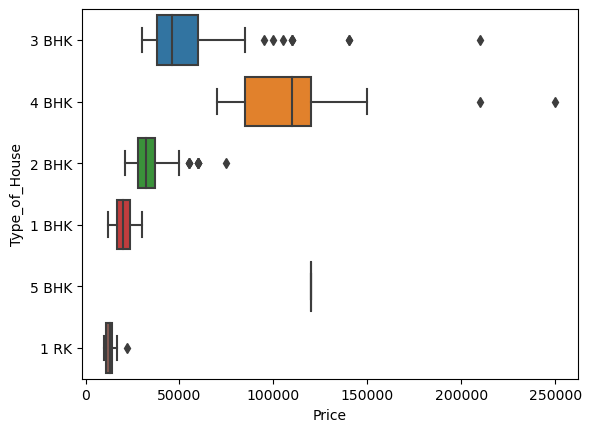

In [72]:
sns.boxplot(x = df["Price"], y = df["Type_of_House"])

#### Observations

1. The price data of 5BHK is symmetric and 1BHK is approximately symmetric but 3BHK, 2BHK, 4BHK 's price data is highly     positvely skewed. So there may be chance of outliers in 3BHK, 2BHK and 4BHK.
--------------------------------------------------------------------------------------------------------------------------
2. Only 4BHK,3BHK and 5BHK flats prices are more than 1,00,000/- and almost are only 4BHK flats.
3. Spread of price data is moderate in each type of house.


In [73]:
gp_Type.agg({"Area_in_sqft" : ["mean", "median", "skew", "std", "min", "max", "count"]})

Area_in_sqft                                                 
                      mean  median      skew          std   min   max count
Type_of_House                                                              
1 BHK           708.683486   700.0  1.203519   145.782098   350  1400   218
1 RK            630.888889   542.0  0.440206   140.538646   500   850     9
2 BHK          1268.856459  1200.0  5.153198   294.645906   685  3900   209
3 BHK          1979.684685  1850.0  2.262271   581.520483  1136  5000   111
4 BHK          3829.473684  3731.0  0.416101  1138.116054  2050  6000    19
5 BHK          4250.000000  4250.0       NaN  1060.660172  3500  5000     2

<Axes: xlabel='Area_in_sqft', ylabel='Type_of_House'>

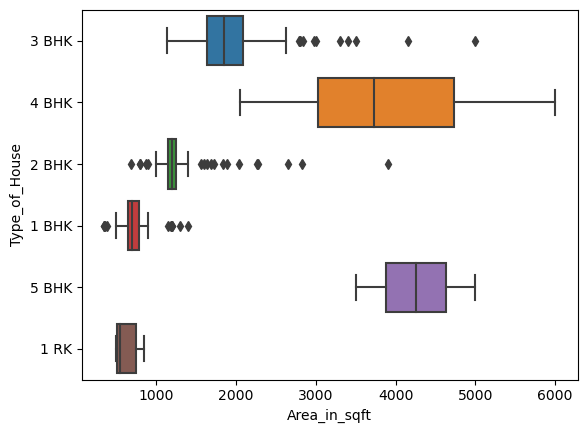

In [74]:
sns.boxplot(x = df["Area_in_sqft"], y = df["Type_of_House"])

#### Observations

1. The Area(in sq.ft) data of 5BHK is symmetric and 4BHK is approximately symmetric but 2BHK, 3BHK, 1BHK 's price data is highly     positvely skewed. So there may be chance of outliers in 2BHK, 3BHK and 1BHK.
--------------------------------------------------------------------------------------------------------------------------
2. Outliers of Area(in sq.ft) data are more in 2BHK flats followed by 3BHK then by 1BHK.

##### Location vs Price

In [75]:
gp_L.agg({"Price" : ["mean", "median", "skew", "std", "min", "max", "count"]})["Price"].sort_values(by = "mean", ascending = False)

,mean,median,skew,std,min,max,count
Location,,,,,,,
Shaikpet,210000.000000,210000.0,NaN,NaN,210000,210000,1
Narsingi,162500.000000,162500.0,NaN,123743.686708,75000,250000,2
Peeramcheru,110024.500000,110024.5,NaN,0.707107,110024,110025,2
Jubilee Hills,100000.000000,100000.0,NaN,NaN,100000,100000,1
Tellapur,98004.800000,110012.0,-0.812706,26836.617581,60000,120012,5
Toli Chowki,95000.000000,100000.0,-0.782152,27838.821814,65000,120000,3
Kokapet,85666.666667,75000.0,2.222205,44495.828882,45000,210000,12
Nallagandla,80430.285714,60000.0,0.595908,44586.889185,28000,140000,7
Kukatpally,80002.500000,60000.0,1.276012,41107.785607,45000,150000,6


#### Observations 
+ Shaikpet has highest mean price 210000/- followed by Narsingi about 160000/-
+ Hafeezpet has lowest mean price about 25000/-

##### Furnish vs Price

In [76]:
gp_F = df.groupby(by = "Furnish")
gp_F.agg({"Price" : ["mean", "median", "skew", "std", "min", "max", "count"]})

Price                                                  \
                         mean   median      skew           std    min     max   
Furnish                                                                         
Fully Furnished  40265.185000  35000.0  3.288488  28984.546227  14000  210000   
Semi Furnished   34524.522936  28500.0  3.902767  23396.598414  10000  250000   
Unfurnished      16512.243902  15000.0  2.006218   4827.654336  10000   35000   

                       
                count  
Furnish                
Fully Furnished   200  
Semi Furnished    327  
Unfurnished        41

#### Observations
+ The average price of fully furnished houses/flats is about 40000/- 
+ Prices are more according to the improvment in furnishing of house.


##### Price vs Area_in_sqft

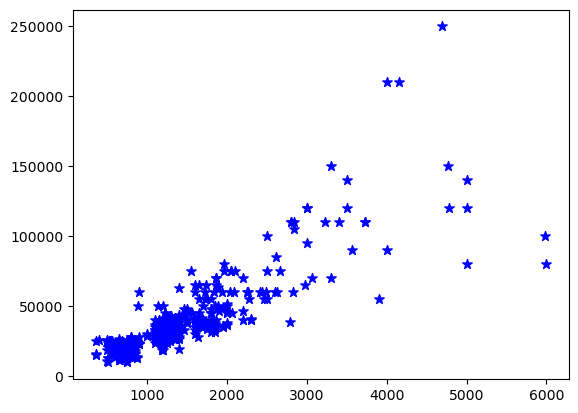

In [78]:
#scatter plot

plt.scatter(x = df["Area_in_sqft"], y = df["Price"], marker ="*", c = "blue", s = 50)

C:\Users\katukuri\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\katukuri\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


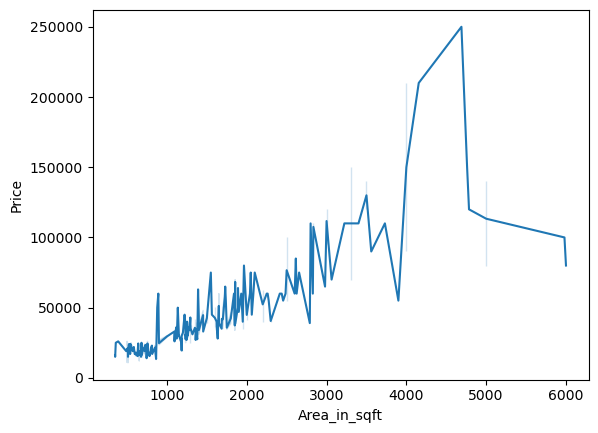

In [79]:
#lineplot

sns.lineplot(x = df["Area_in_sqft"], y = df["Price"])
plt.show()

In [80]:
#multivariate analysis

num_col = ["Price", "Brokerage", "Area_in_sqft"]
corr_PAB = df[num_col].corr()
corr_PAB 

,Price,Brokerage,Area_in_sqft
Price,1.000000,0.962338,0.851242
Brokerage,0.962338,1.000000,0.802660
Area_in_sqft,0.851242,0.802660,1.000000


<Axes: >

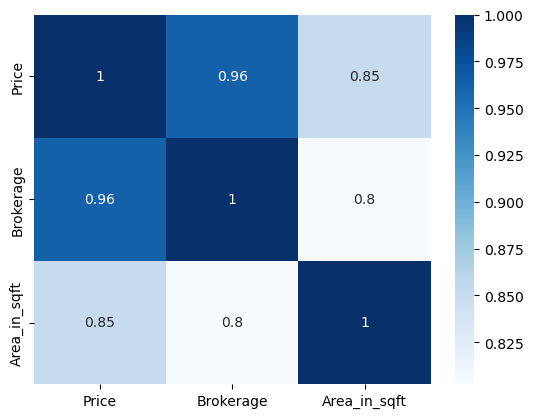

In [81]:
#heatmap

sns.heatmap(corr_PAB, annot = True, cmap = "Blues")

C:\Users\katukuri\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\katukuri\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\katukuri\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


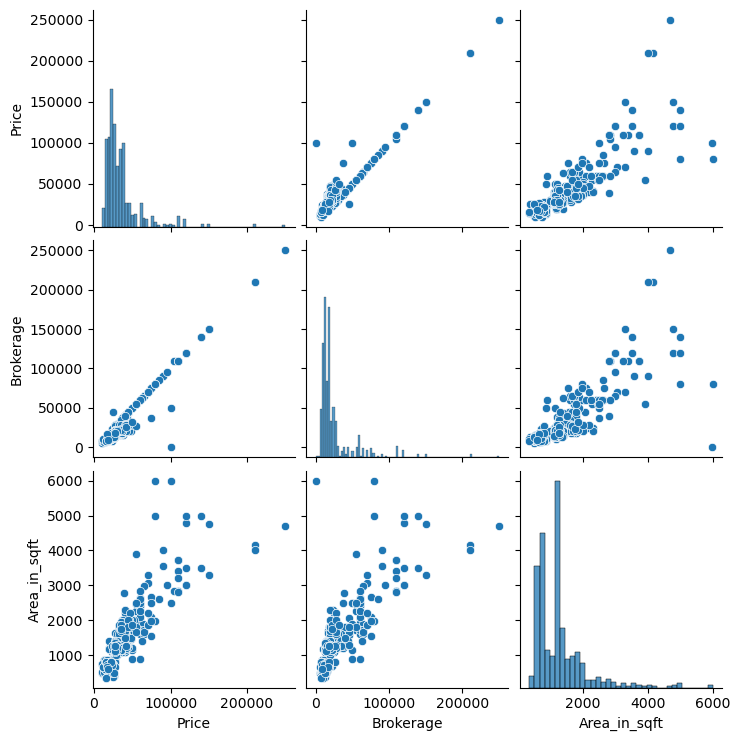

In [82]:
#pairplot

sns.pairplot(df, vars = num_col)

#### Observations

+ Area_in_sqft is impacting greatly on Price of the house.They have strong relation.
+ Price of the house is reflecting on brokerage.They both have strong relation between them almost linear relationship.`

## MULTIVARIATE ANALYSIS

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type_of_House  568 non-null    object 
 1   Property_Type  568 non-null    object 
 2   Price          568 non-null    int64  
 3   Brokerage      567 non-null    float64
 4   Location       568 non-null    object 
 5   Furnish        568 non-null    object 
 6   Area_in_sqft   568 non-null    int64  
 7   Bathrooms      568 non-null    int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 35.6+ KB


##### TypeOfHouse vs Location vs Price

In [84]:
gp_TypeLoc = df.groupby(by = ["Type_of_House" , "Location"])

In [88]:
gp_TypeLoc.agg({"Price" : ["mean", "median", "std", "skew", "count"]})

Price                          \
                                          mean    median           std   
Type_of_House Location                                                   
1 BHK         Hafeezpet           19854.454545   17500.0   4815.466257   
              Kondapur            20217.428571   20000.0   3901.001842   
              Kothaguda           19000.000000   19000.0           NaN   
              Madhapur            21166.666667   23000.0   3175.426481   
1 RK          Kondapur            13444.444444   13000.0   3908.679800   
2 BHK         Borabanda           47500.000000   47500.0   3535.533906   
              Gachibowli          45000.000000   40000.0  13228.756555   
              Hafeezpet           36400.000000   40000.0   6804.410334   
              Kokapet             55000.000000   55000.0           NaN   
              Kondapur            31969.346154   30500.0   5580.663240   
              Kukatpally          55015.000000   55015.0           NaN   
              Madhapur            36600.000000   37000.0   1516.575089   
              Manikonda           60000.000000   60000.0      0.000000   
              Nallagandla         44333.333333   50000.0  14364.307618   
              Nanakaramguda       60000.000000   60000.0           NaN   
              Narsingi            75000.000000   75000.0           NaN   
              Osman Nagar         44000.000000   44000.0           NaN   
              Serilingampally     29000.000000   29000.0   1414.213562   
3 BHK         Banjara Hills       66666.666667   70000.0  10408.329997   
              Borabanda           50000.000000   50000.0           NaN   
              Chitrapuri Colony   45000.000000   45000.0           NaN   
              Gopanapalli         55000.000000   55000.0           NaN   
              Hitech City         65000.000000   65000.0           NaN   
              Jubilee Hills      100000.000000  100000.0           NaN   
              Kokapet             76625.000000   69000.0  25348.640426   
              Kondapur            43642.857143   40000.0  12583.674395   
              Kothaguda           75000.000000   75000.0           NaN   
              Kukatpally          68750.000000   60000.0  28394.541729   
              Madhapur            55000.000000   55000.0           NaN   
              Manikonda           39000.000000   39000.0           NaN   
              Nallagandla        113333.333333  140000.0  46188.021535   
              Nanakaramguda       66428.571429   65000.0   8997.354108   
              Osman Nagar         60000.000000   60000.0           NaN   
              Serilingampally     48250.000000   46500.0  11954.775894   
              Shaikpet           210000.000000  210000.0           NaN   
              Tellapur            60000.000000   60000.0           NaN   
              Toli Chowki         65000.000000   65000.0           NaN   
4 BHK         Hitech City         80000.000000   80000.0           NaN   
              Kokapet            120000.000000   75000.0  77942.286341   
              Kondapur           110000.000000  110000.0           NaN   
              Kukatpally         150000.000000  150000.0           NaN   
              Madhapur           130000.000000  120000.0  17320.508076   
              Nallagandla         90012.000000   90012.0           NaN   
              Nanakaramguda       90000.000000   90000.0           NaN   
              Narsingi           250000.000000  250000.0           NaN   
              Nizampet            70000.000000   70000.0           NaN   
              Peeramcheru        110024.500000  110024.5      0.707107   
              Tellapur            95006.000000   95006.0  21221.688717   
              Toli Chowki        110000.000000  110000.0  14142.135624   
5 BHK         Tellapur           120006.000000  120006.0      8.485281   

                                                 
                                     skew count  
Type_of_House Loca

##### TypeOfHouse vs Location vs Area

In [86]:
gp_TypeLoc.agg({"Area_in_sqft" : ["mean", "max", "min"]})

Area_in_sqft            
                                        mean   max   min
Type_of_House Location                                  
1 BHK         Hafeezpet           698.090909   850   520
              Kondapur            707.044335  1400   350
              Kothaguda          1184.000000  1184  1184
              Madhapur            700.000000   700   700
1 RK          Kondapur            630.888889   850   500
2 BHK         Borabanda          1220.500000  1563   878
              Gachibowli         1490.000000  2040  1200
              Hafeezpet          1347.600000  1688  1200
              Kokapet            2275.000000  2275  2275
              Kondapur           1218.225275  1840   685
              Kukatpally         3900.000000  3900  3900
              Madhapur           1300.000000  1600  1200
              Manikonda          2545.000000  2828  2262
              Nallagandla        1637.666667  1888  1300
              Nanakaramguda       892.000000   892   892
              Narsingi           2656.000000  2656  2656
              Osman Nagar        1399.000000  1399  1399
              Serilingampally    1100.000000  1200  1000
3 BHK         Banjara Hills      2400.000000  2500  2200
              Borabanda          1136.000000  1136  1136
              Chitrapuri Colony  2063.000000  2063  2063
              Gopanapalli        2456.000000  2456  2456
              Hitech City        1730.000000  1730  1730
              Jubilee Hills      2500.000000  2500  2500
              Kokapet            2242.750000  3000  1390
              Kondapur           1795.814286  2835  1358
              Kothaguda          1550.000000  1550  1550
              Kukatpally         2386.250000  3400  1800
              Madhapur           1800.000000  1800  1800
              Manikonda          2790.000000  2790  2790
              Nallagandla        3408.333333  5000  1725
              Nanakaramguda      2241.285714  3300  1600
              Osman Nagar        2250.000000  2250  2250
              Serilingampally    1485.750000  1890  1200
              Shaikpet           4155.000000  4155  4155
              Tellapur           2083.000000  2083  2083
              Toli Chowki        2981.000000  2981  2981
4 BHK         Hitech City        5000.000000  5000  5000
              Kokapet            2700.000000  4000  2050
              Kondapur           2835.000000  2835  2835
              Kukatpally         4761.000000  4761  4761
              Madhapur           3100.000000  3300  3000
              Nallagandla        4000.000000  4000  4000
              Nanakaramguda      3560.000000  3560  3560
              Narsingi           4690.000000  4690  4690
              Nizampet           3063.000000  3063  3063
              Peeramcheru        3731.000000  3731  3731
              Tellapur           4611.500000  6000  3223
              Toli Chowki        5383.000000  5981  4785
5 BHK         Tellapur           4250.000000  5000  3500

##### TypeOfHouse vs Location vs Furnish

In [87]:
#Pivot Table

df.pivot_table(index = ["Type_of_House", "Location"], columns = "Furnish", values = "Area_in_sqft", aggfunc = "count", margins = True, margins_name = "Total")

Furnish                          Fully Furnished  Semi Furnished  Unfurnished  \
Type_of_House Location                                                          
1 BHK         Hafeezpet                      5.0             5.0          1.0   
              Kondapur                      81.0            89.0         33.0   
              Kothaguda                      NaN             1.0          NaN   
              Madhapur                       2.0             1.0          NaN   
1 RK          Kondapur                       3.0             3.0          3.0   
2 BHK         Borabanda                      2.0             NaN          NaN   
              Gachibowli                     1.0             2.0          NaN   
              Hafeezpet                      NaN             5.0          NaN   
              Kokapet                        NaN             1.0          NaN   
              Kondapur                      58.0           120.0          4.0   
              Kukatpally                     NaN             1.0          NaN   
              Madhapur                       4.0             1.0          NaN   
              Manikonda                      NaN             2.0          NaN   
              Nallagandla                    NaN             3.0          NaN   
              Nanakaramguda                  1.0             NaN          NaN   
              Narsingi                       NaN             1.0          NaN   
              Osman Nagar                    NaN             1.0          NaN   
              Serilingampally                NaN             2.0          NaN   
3 BHK         Banjara Hills                  2.0             1.0          NaN   
              Borabanda                      NaN             1.0          NaN   
              Chitrapuri Colony              NaN             1.0          NaN   
              Gopanapalli                    NaN             1.0          NaN   
              Hitech City                    NaN             1.0          NaN   
              Jubilee Hills                  1.0             NaN          NaN   
              Kokapet                        6.0             2.0          NaN   
              Kondapur                      14.0            56.0          NaN   
              Kothaguda                      NaN             1.0          NaN   
              Kukatpally                     1.0             3.0          NaN   
              Madhapur                       NaN             1.0          NaN   
              Manikonda                      NaN             1.0          NaN   
              Nallagandla                    3.0             NaN          NaN   
              Nanakaramguda                  3.0             4.0          NaN   
              Osman Nagar                    1.0             NaN          NaN   
              Serilingampally                2.0             2.0          NaN   
              Shaikpet                       1.0             NaN          NaN   
              Tellapur                       1.0             NaN          NaN   
              Toli Chowki                    1.0             NaN          NaN   
4 BHK         Hitech City                    1.0             NaN          NaN   
              Kokapet                        1.0             2.0          NaN   
              Kondapur                       NaN             1.0          NaN   
              Kukatpally                     NaN             1.0          NaN   
              Madhapur                       3.0             NaN          NaN   
              Nallagandla                    NaN             1.0          NaN   
              Nanakaramguda                  NaN             1.0          NaN   
              Narsingi                       NaN             1.0          NaN   
              Nizampet                       NaN             1.0          NaN   
              Peeramcheru                    1.0             1.0          NaN   
              Tellapur         

#### Observations

1. 1BHK 
 + The mean price is highest at Madhapur about 21000/- with low average area available ans also with either fully furnished or semi furnished but deviation of prices is low compared to other locations.
 + Kothaguda has lowest mean price with high area available.
 
2. 1RK
 + 1RK flats are available only at kondapur with mean price about 13000/- with readonable area(in sq.ft) and all three types of furnishing is available.So can choose as our requirements.
 
3. 2BHK
 + Kondapur has huge no of flats with least mean price and average area is low compared to many other locations but most of them are semi furnished. 

4. 3BHK 
 + Same as 2BHK situation in kondapur.
 + But irrespective of place selection, choosing Manikonda with least mean price, semi furnished and with high available area within that price is best option .

5. 4BHK
 + Nizampet has least mean price followed by Hitech city but Hitech city's average area is more compared to Nizampet and also flats in hitech city are fully furnished.

6. 5BHK 
 + Only available at Tellapur with prices 120000/- with reasonable area(in sq.ft) and also semi furnished.


##### TypeOfHouse vs Price vs Area

In [89]:
gp_Type = df.groupby(by = "Type_of_House")
gp_Type[["Price","Area_in_sqft"]].corr()

Price  Area_in_sqft
Type_of_House                                     
1 BHK         Price         1.000000      0.070393
              Area_in_sqft  0.070393      1.000000
1 RK          Price         1.000000      0.400141
              Area_in_sqft  0.400141      1.000000
2 BHK         Price         1.000000      0.594536
              Area_in_sqft  0.594536      1.000000
3 BHK         Price         1.000000      0.767605
              Area_in_sqft  0.767605      1.000000
4 BHK         Price         1.000000      0.190980
              Area_in_sqft  0.190980      1.000000
5 BHK         Price         1.000000     -1.000000
              Area_in_sqft -1.000000      1.000000

<Axes: xlabel='Area_in_sqft', ylabel='Price'>

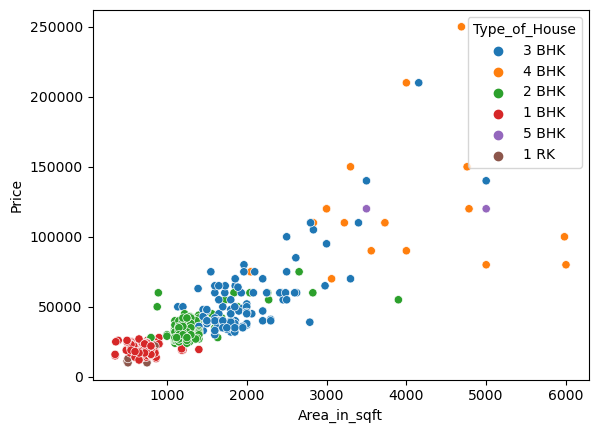

In [90]:
sns.scatterplot(x= df["Area_in_sqft"], y = df["Price"], hue = df["Type_of_House"])

#### Observations

+ Only 2BHK and 3BHK flats Area_in_sqft have moderate impact on price.
+ All other flats have very less impact.

# Conclusions

1. Average price of houses is about 35000/-
2. As mean of the price is around 35000, so most of the price of houses might be around 35000 Rs/-
------------------------------------------------------------------------------------------------------------------------------
3. According the the above analysis,the median price is about 28000/-
4. So from the above numbers we can interpret that there might chance of outliers at postive side
    because mean is greater than median, which indicates that very few houses have higher prices.
------------------------------------------------------------------------------------------------------------------------------   
5. Most of the houses prices are about 25000/-
6. mean > median > mode
------------------------------------------------------------------------------------------------------------------------------
7. Majority of the prices are in the range of 10000 to 34000 followed by 34000 to 58000
8. Very few houses/flats are at higher price.
------------------------------------------------------------------------------------------------------------------------------
9. The prices of houses data is highly positive skew.
10. Most of the houses are at lower price and very few are at higher price.
------------------------------------------------------------------------------------------------------------------------------
11. Almost 75% of the houses are at price below 50000/-
12. The spread of the data is less
------------------------------------------------------------------------------------------------------------------------------
13. 1BHK flats/houses are top in count i.e 218 houses followed by 2BHK(109 houses).
14. 5BHK flats/houses are least in count(only 2 houses).
------------------------------------------------------------------------------------------------------------------------------
15. Almost 38% of houses are of 1BHK followed by 2BHK with 36%.
16. Only 0.4% of houses are 5BHK which is very low category.
------------------------------------------------------------------------------------------------------------------------------
17. Almost all the houses are flats in an apartment i.e about 98%.
------------------------------------------------------------------------------------------------------------------------------
18. Almost all houses are available at Kondapur.
19. Many places like Shaikpet, Jubilee Hills, Nizampet, Chitrapuri Colony, Gopanapalli atmost have 1 house.  
------------------------------------------------------------------------------------------------------------------------------
20. Almost 58% of houses are semi furnished followed by fully furnished with 35%.
21. Only 7.2% of houses are not furnished.
------------------------------------------------------------------------------------------------------------------------------
22. All types of houses are present in kondapur but 5BHK and 4BHK counts are very less compared to other types.
23. All other locations have very less no of houses(including type of houses) compared to kondapur.
24. 5BHK flats are present only at Tellapur.
------------------------------------------------------------------------------------------------------------------------------
25. 3BHK flats are present at many locations(19 locations) followed by 2BHK and 4BHK flats at 13 and 12 locations respectively.
26. 5BHK flats are present onlt at one location and 1RK flats are present only at 1 locations.
------------------------------------------------------------------------------------------------------------------------------
27. Semi furnished are most 2BHK followed by 1BHK then followed by 3BHK.
28. Fully Furnished are most 1BHK followed by 2BHK.
29. Very less 2BHK are not furnished.
30. none of 3BHK, 4BHK, 5BHK flats remained unfurnished.
-------------------------------------------------------------------------------------------------------------------------------
31. Almost all houses at all locations are either fully or semi furnished except kondapur and hafeezpet.
-------------------------------------------------------------------------------------------------------------------------------
32. The price data of 5BHK is symmetric and 1BHK is approximately symmetric but 3BHK, 2BHK, 4BHK 's price data is highly     positvely skewed. So there may be chance of outliers in 3BHK, 2BHK and 4BHK.
--------------------------------------------------------------------------------------------------------------------------
33. Only 4BHK,3BHK and 5BHK flats prices are more than 1,00,000/- and almost are only 4BHK flats.
34. Spread of price data is moderate in each type of house.
-------------------------------------------------------------------------------------------------------------------------------
35. The Area(in sq.ft) data of 5BHK is symmetric and 4BHK is approximately symmetric but 2BHK, 3BHK, 1BHK 's price data is highly positvely skewed. So there may be chance of outliers in 2BHK, 3BHK and 1BHK.
36. Outliers of Area(in sq.ft) data are more in 2BHK flats followed by 3BHK then by 1BHK.
------------------------------------------------------------------------------------------------------------------------------
37. Shaikpet has highest mean price 210000/- followed by Narsingi about 160000/-
38. Hafeezpet has lowest mean price about 25000/-
39. The average price of fully furnished houses/flats is about 40000/- 
40. Prices are more according to the improvment in furnishing of house.
------------------------------------------------------------------------------------------------------------------------------
41. Area_in_sqft is impacting greatly on Price of the house.They have strong relation.
42. Price of the house is reflecting on brokerage.They both have strong relation between them almost linear relationship.`
-------------------------------------------------------------------------------------------------------------------------------
43. 1BHK 
 + The mean price is highest at Madhapur about 21000/- with low average area available ans also with either fully furnished or semi furnished but deviation of prices is low compared to other locations.
 + Kothaguda has lowest mean price with high area available.
 
44. 1RK
 + 1RK flats are available only at kondapur with mean price about 13000/- with readonable area(in sq.ft) and all three types of furnishing is available.So can choose as our requirements.
 
45. 2BHK
 + Kondapur has huge no of flats with least mean price and average area is low compared to many other locations but most of them are semi furnished. 

46. 3BHK 
 + Same as 2BHK situation in kondapur.
 + But irrespective of place selection, choosing Manikonda with least mean price, semi furnished and with high available area within that price is best option .

47. 4BHK
 + Nizampet has least mean price followed by Hitech city but Hitech city's average area is more compared to Nizampet and also flats in hitech city are fully furnished.

48. 5BHK 
 + Only available at Tellapur with prices 120000/- with reasonable area(in sq.ft) and also semi furnished.
-------------------------------------------------------------------------------------------------------------------------------
49. Only 2BHK and 3BHK flats Area_in_sqft have moderate impact on price.
50. All other flats have very less impact.
